In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import Adam
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments
from copy import deepcopy
import copy
import logging
import json
from dataclasses import dataclass
import numpy
import pandas as pd
from typing import Optional, Dict, Sequence

device = "cuda" if torch.cuda.is_available() else "cpu"

print("Torch version:{}".format(torch.__version__)) # Torch version:1.12.1
print("Cuda version: {}".format(torch.version.cuda)) # Cuda version: 11.3
print("transformers version: {}".format(transformers.__version__)) # transformers 4.28.0
print("GPU 사용 가능여부: {}".format(torch.cuda.is_available()))

Torch version:1.12.1
Cuda version: 11.3
transformers version: 4.28.0
GPU 사용 가능여부: True


In [2]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

In [3]:
#torch.cuda.empty_cache()

In [4]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

# 0. 전처리된 데이타 파일 로딩

In [5]:
data_save_path_SFT = './data/clean_kochatgpt_1_SFT.jsonl'

In [6]:


#with open(data_save_path_SFT, "r", encoding='utf-8-sig') as json_file:
#    sft_data_dict = json.load(json_file)

#print(len(sft_data_dict))
#sft_data_dict[:3]

## 공통 함수

In [10]:
import math
from datasets import load_metric

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    # shift so that tokens <n> predict <n+1>
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()

    # Flatten for loss calculation
    loss_fct = torch.nn.CrossEntropyLoss(ignore_index=-100)
    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    
    # Perplexity
    perplexity = math.exp(loss.item())

    return {
        "loss": loss.item(),
        "perplexity": perplexity
    }

In [12]:
import matplotlib.pyplot as plt

def display_train_graph(logs) : 
    
    for log in logs:
        if 'eval_loss' in log:
            print(f"Step: {log.get('step')}, Epoch: {log.get('epoch')}, Eval Loss: {log.get('eval_loss')}")
        if 'loss' in log:
            print(f"Step: {log.get('step')}, Epoch: {log.get('epoch')}, Loss: {log.get('loss')}")
        if 'perplexity' in log:
            print(f"Step: {log.get('step')}, Epoch: {log.get('epoch')}, Perplexity: {log.get('perplexity')}")
    
    
    train_loss = [log["loss"] for log in logs if "loss" in log]
    steps = list(range(1, len(train_loss) + 1))
    
    eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]
    #eval_acc = [log["eval_accuracy"] for log in logs if "eval_accuracy" in log]
    #eval_f1 = [log["eval_f1"] for log in logs if "eval_f1" in log]
    # eval_steps = list(range(1, len(eval_loss)) )
    
    # train_loss 길이에 맞춰 eval_loss, eval_acc, eval_f1 자르기
    eval_loss = eval_loss[:len(train_loss)]
    #eval_acc = eval_acc[:len(train_loss)]
    #eval_f1 = eval_f1[:len(train_loss)]
    eval_steps = steps

    # 그래프 그리기
    plt.figure(figsize=(12, 5))

    # Loss 그래프
    
    plt.plot(steps, train_loss, label="Train Loss") 
    plt.plot(steps, eval_loss, label="Val Loss", color="red")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train Loss per Epoch")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [13]:
from rouge import Rouge
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_rouge(refs, preds): 
    rouge = Rouge()
    all_scores = []
    results = []
    
    for ref, pred in zip(refs, preds):
        if ref.strip() == "" or pred.strip() == "":
            continue
        
        score = rouge.get_scores(pred, ref)[0]
        all_scores.append(score)
        
        results.append({
            'ROUGE-1': score['rouge-1']['f'],
            'ROUGE-2': score['rouge-2']['f'],
            'ROUGE-L': score['rouge-l']['f']
        })
    
    # 평균값
    rouge_1 = np.mean([s['rouge-1']['f'] for s in all_scores])
    rouge_2 = np.mean([s['rouge-2']['f'] for s in all_scores])
    rouge_l = np.mean([s['rouge-l']['f'] for s in all_scores])
    
    print("📊 평균 ROUGE 점수")
    print(f"ROUGE-1 F1: {rouge_1:.4f}")
    print(f"ROUGE-2 F1: {rouge_2:.4f}")
    print(f"ROUGE-L F1: {rouge_l:.4f}") 
    
    # 그래프
    df = pd.DataFrame(results)
 
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df[['ROUGE-1', 'ROUGE-2', 'ROUGE-L']])
    plt.title("ROUGE Score Distribution")
    plt.show()


# 1. KOGPT2 모델

In [10]:
model_name = "skt/kogpt2-base-v2"
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)  # GPU 또는 CPU

tokenizer = AutoTokenizer.from_pretrained(
    model_name, bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    #model_max_length=512,
    model_max_length=384,           # CUDA OOM 문제로 줄여보자!!
)
print(tokenizer)

GPT2TokenizerFast(name_or_path='skt/kogpt2-base-v2', vocab_size=51200, model_max_length=384, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=True)


In [11]:
@dataclass
class DataCollatorForSupervisedDataset(object): 

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        # batch 내 label 시퀀스를 길이에 맞춰 패딩(padding)
        # padding_value= -100 : 짧은 시퀀스를 맞추기 위해 채울 값
        # PyTorch의 nn.CrossEntropyLoss()에서는 ignore_index=-100이 기본값
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value= -100)
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

In [38]:
class KoGPT_dataset(Dataset):

    def __init__(self, data_path_1_SFT: str, tokenizer: transformers.PreTrainedTokenizer, verbose=False):
        super(KoGPT_dataset, self).__init__()
        logging.warning("Loading data...")

        with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
            list_data_dict = json.load(json_file)

        sources = []
        targets = []
        for example in list_data_dict:
            sources.append(example['prompt'])
            targets.append(example['completion'] + tokenizer.eos_token)
          
        examples = [s + t for s, t in zip(sources, targets)]

        # sources_tokenized는 **입력 마스킹(masking)**에 쓰이고,
        # examples_tokenized는 전체 학습 텍스트 + 레이블용 토큰이다
        sources_tokenized = self._tokenize_fn(sources, tokenizer)  # source
        examples_tokenized = self._tokenize_fn(examples, tokenizer)  # source + target

        source_ids = sources_tokenized["input_ids"]
        input_ids = examples_tokenized["input_ids"]
        # loss 계산시 label을 정의하는 부분으로, input_ids를 그대로 copy하되
        # prompt 부분은 필요없으므로 lable에서 prompt 부분은 -100으로 masking한다. 
        labels = copy.deepcopy(input_ids)
        for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
            label[:source_len] = -100
       

        data_dict = dict(input_ids=input_ids, labels=labels, source_ids=source_ids)

        self.input_ids = data_dict["input_ids"]
        self.labels = data_dict["labels"]
        self.source_ids = data_dict["source_ids"]
        logging.warning("Loading data done!!: %d"%(len(self.labels)))


    def _tokenize_fn(self, strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer) -> Dict:
        tokenized_list = [
            tokenizer(
                text,
                return_tensors="pt",
                padding="longest",
                max_length=tokenizer.model_max_length,
                truncation=True,
            )
            for text in strings
        ]
        input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
        input_ids_lens = labels_lens = [
            tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list
        ]
        return dict(
            input_ids=input_ids,
            labels=labels,
            input_ids_lens=input_ids_lens,
            labels_lens=labels_lens,
        )


    def __len__(self):
        return len(self.input_ids)


    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i], source_ids=self.source_ids[i])


In [40]:
kg_train_dataset = KoGPT_dataset(data_path_1_SFT=data_save_path_SFT, tokenizer=tokenizer)
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

print(type(kg_train_dataset))
print(len(kg_train_dataset))
print('input : %s'%kg_train_dataset.input_ids[0])
print('output: %s'%kg_train_dataset.labels[0])
print('source: %s'%kg_train_dataset.source_ids[0])

<class '__main__.KoGPT_dataset'>
11992
input : tensor([ 9128, 20479,  8091, 22311,  9036, 30902,  8084,   739,   406, 37767,
        13753,  8263,  7166,   739,  8352,  7659,  9639, 11481, 25585, 13600,
         8022,  9378, 11532,  9887, 11218,  9111, 16913,  7182, 36510, 10351,
        10561,  9128, 20479,  8091,  9065,  9446, 33869, 11481, 46311, 11481,
        26367,  6958,  9030,  9882, 12317, 25882,  9209,  8708,  7172,  7182,
        36510, 10351,  9036, 12168, 10529, 15989,  9719, 15434, 10552, 11188,
         9355, 11481,  9036, 15805, 11300, 11846,  9146, 16913,  7182, 36510,
         9181,  7397, 15806, 13480, 11342, 17596,  9161, 19996,  9025, 25006,
        18595,  9966, 12592, 10751, 11814,  8711,  9046, 12450,  9117,  7377,
         7172,  7182, 36510,     1])
output: tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100, 37767,
        13753,  8263,  7166,   739,  8352,  7659,  9639, 11481, 25585, 13600,
         8022,  9378, 11532,  9887, 11218,  9111, 

In [14]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  501216 KB |  501216 KB |  501216 KB |       0 B  |
|       from large pool |  488448 KB |  488448 KB |  488448 KB |       0 B  |
|       from small pool |   12768 KB |   12768 KB |   12768 KB |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |  501216 KB |  501216 KB |  501216 KB |       0 B  |
|       from large pool |  488448 KB |  488448 KB |  488448 KB |

In [31]:
# train_dataset.input_ids[0]를 디코딩해보세요.
input_text = tokenizer.decode(kg_train_dataset.input_ids[0] , skip_special_tokens=True)
label_text = tokenizer.decode([token for token in  kg_train_dataset.labels[0]  if token != -100], skip_special_tokens=True)
prompt_text = tokenizer.decode(kg_train_dataset.source_ids[0] , skip_special_tokens=True)

print(f"[INPUT]:\n{input_text}\n")
print(f"[LABEL]:\n{label_text}\n")
print(f"[PROMPT]:\n{prompt_text}\n")

[INPUT]:
불고기용 고기 한우에요?저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.

[LABEL]:
저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.

[PROMPT]:
불고기용 고기 한우에요?



In [41]:
from torch.utils.data import random_split

total_len = len(kg_train_dataset)

# train 80%, val 10%, test 10%로 나누기
train_size = int(0.8 * total_len)
val_size = int(0.1 * total_len)
test_size = total_len - train_size - val_size  # 남는 거 처리

# 랜덤 시드 고정
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(kg_train_dataset, [train_size, val_size, test_size], generator=generator)


print(f"Train: {len(train_dataset)}")
print(f"Validation: {len(val_dataset)}")
print(f"Test: {len(test_dataset)}")

Train: 9593
Validation: 1199
Test: 1200


**Trainer**

In [42]:
test_dataset[0]

{'input_ids': tensor([ 9202,  7536, 12622, 17885,  7661,   392, 36510, 14553, 10667,  9867,
         49165,  9067, 10233,  9117,  7748,  9173,  9290, 12519, 14553, 10667,
          9867,  9316,  9202,  9883,  9337,  9025,  9019, 16913,  7182, 36510,
          9045, 36510,  9032, 13041,  9183,  9677, 11117, 26512, 18026,  9183,
          9677, 11117, 49165,  9067, 10002, 11312,  8137,  9350, 19377,  9202,
          9883,  9337,  9025,  9019, 16913,  7182, 36510,  9085, 36510, 24878,
         12222, 11814,  8718, 10247, 11018,  7055, 15454,  9337,  9068, 45568,
         17437,  7055, 14795, 18422, 11814,  9328, 27728, 11312,  9956, 11615,
         23523,  9202,  9883,  9337,  9025,  9019, 16913,  7182, 36510,  9130,
         36510, 11342,  9694, 12519, 11342, 32563, 10407, 49165,  9067, 10002,
         11312,  9956, 11615, 23523,  9202,  9883,  9337,  9025,  9019, 16913,
          7182, 36510,  9143, 36510,  9306, 12519, 10407, 13814,  8420, 11335,
         49165, 22364, 10407, 49165,  9

In [14]:
output_dir = os.getenv('HOME')+'/aiffel/KoChatGPT/test'

training_args = TrainingArguments(
    output_dir,
    overwrite_output_dir=True,
    evaluation_strategy="epoch",        #evaluation하는 빈도
    logging_strategy="epoch",           # epoch마다 로그 기록
    learning_rate = 2e-5,               #learning_rate
    num_train_epochs=3,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    warmup_steps=5,
    prediction_loss_only=True,  # CUDA OOM하고 연관 있나?
    logging_dir="./kogpt_logs",
    fp16 = True
    )

trainer = Trainer(
    model=model,
    
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset, 
    tokenizer=tokenizer,
    compute_metrics=compute_metrics 
)

In [ ]:
output_dir = os.getenv('HOME')+'/aiffel/KoChatGPT/test'

#training_args = TrainingArguments(
    output_dir,
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    warmup_steps=5,
    prediction_loss_only=True,
    fp16 = True
    )

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

In [18]:
trainer.train()
model.save_pretrained('./modles/output_1_KoGPT')

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.556800,2.297744


In [ ]:
trainer.evaluate(test_dataset)

In [19]:
for log in trainer.state.log_history:
    if 'eval_loss' in log:
        print(f"Step: {log.get('step')}, Epoch: {log.get('epoch')}, Eval Loss: {log.get('eval_loss')}")
    if 'loss' in log:
        print(f"Step: {log.get('step')}, Epoch: {log.get('epoch')}, Loss: {log.get('loss')}")
    if 'perplexity' in log:
        print(f"Step: {log.get('step')}, Epoch: {log.get('epoch')}, Perplexity: {log.get('perplexity')}")

Step: 9593, Epoch: 1.0, Loss: 2.5568
Step: 9593, Epoch: 1.0, Eval Loss: 2.297744035720825


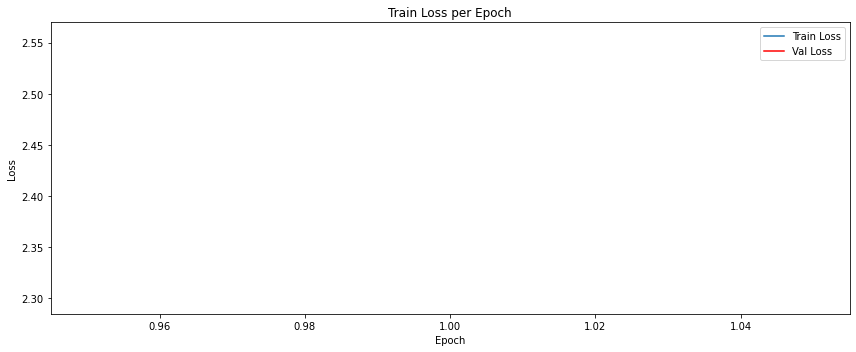

In [20]:
# 학습 후 로그 가져오기
kogpt_logs = trainer.state.log_history

display_train_graph(logs = kogpt_logs)

**generate**

In [13]:

inputs = []
for idx, data in enumerate(kg_train_dataset) : 
    input_ids = data['input_ids']
    input_text = tokenizer.decode(input_ids , skip_special_tokens=True)
    
    inputs.append(input_text)
    
print(len(inputs))
print(inputs[0])

11992


In [15]:

labels = []
for idx, data in enumerate(kg_train_dataset) : 
    label_ids = data['labels']
    label_text = tokenizer.decode([token for token in  label_ids  if token != -100], skip_special_tokens=True)
    
    labels.append(label_text)
    
print(len(labels))
print(labels[0])

11992


In [43]:
generator = pipeline('text-generation', model='./modles/output_1_KoGPT', tokenizer=tokenizer)
#generator = pipeline('text-generation', model=model, tokenizer=tokenizer)

generation_args = dict(   
    num_beams=4,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id= tokenizer.eos_token_id, #375, # \n   
    temperature=1.0,
    max_new_tokens=64,
    do_sample=True,
    top_k=50,
    early_stopping=True
)


test_count = 100 # 개수를 줄여보자

# inputs
inputs = []
for idx, data in enumerate(test_dataset) : 
    if idx >= test_count :
        break
    input_ids = data['source_ids']
    input_text = tokenizer.decode(input_ids , skip_special_tokens=True)
    
    inputs.append(input_text)
    
print(len(inputs))


# references 
ref_labels = []
for idx, data in enumerate(test_dataset) : 
    if idx >= test_count :
        break
    label_ids = data['labels']
    label_text = tokenizer.decode([token for token in  label_ids  if token != -100], skip_special_tokens=True)
    
    ref_labels.append(label_text)
    
print(len(ref_labels))


# predictions 
#pred_results = generator(inputs, **generation_args)


from tqdm import tqdm

pred_results = []
for input_text in tqdm(inputs, desc="Generating"):
    result = generator(input_text, **generation_args)
    pred_results.append(result)



100
100


Generating: 100%|██████████| 100/100 [04:55<00:00,  2.96s/it]


In [44]:
print(type(pred_results))
pred_results[0]

<class 'list'>


[{'generated_text': '변명거리 생각해봐제가 ai 챗봇이기 때문에, 어떤 문제가 있는지 자세히 설명해주시면 답변을 드릴 수 있을 것 같습니다.'}]

In [45]:
cnt = 0
for prompt, ref, result in zip(inputs, ref_labels, pred_results):
    print()
    print("[Prompt]", prompt)
    print("[Ref   ]", ref)
    print("[Gen   ]", (result[0]['generated_text']))
    cnt +=1
    if cnt >= 3 :
        break


[Prompt] 변명거리 생각해봐
[Ref   ] 1. 시간이 부족해서 일이나 공부가 바쁘다는 것을 이유로 시간이 부족해서라는 변명을 할 수 있습니다. 2. 기분이 안 좋아서 정신적인 상태가 안 좋아서 일이나 공부에 집중을 못하겠다는 변명을 할 수 있습니다. 3. 장소를 잘못 선택했어서 공부나 작업을 할 때 조용한 장소나 적절한 공간을 선택하지 않아서 집중력이 떨어졌다는 변명을 할 수 있습니다. 4. 건강상의 이유로 건강문제로 인해 일이나 공부에 집중력이 떨어졌다는 변명을 할 수 있습니다. 5. 다른 이유로 인해 예상치 못한 일이나 사건으로 인해 일이나 공부에 집중력이 떨어졌다는 변명을 할 수 있습니다.
[Gen   ] 변명거리 생각해봐제가 ai 챗봇이기 때문에, 어떤 문제가 있는지 자세히 설명해주시면 답변을 드릴 수 있을 것 같습니다.

[Prompt] 방탄소년단은 한국 가수 최초로 몇 개의 앨범이 연속으로 빌보드 200차트에 올랐나?
[Ref   ] 방탄소년단은 5개의 앨범이 연속으로 빌보드 200차트에 올랐습니다. the most beautiful moment in life, part 2, the most beautiful moment in life young forever, wings, love yourself her, love yourself tear
[Gen   ] 방탄소년단은 한국 가수 최초로 몇 개의 앨범이 연속으로 빌보드 200차트에 올랐나?방탄소년단은 2016년 발매한 방탄소년단의 앨범의 수록곡 중 하나인 방탄소년단 입니다., token 97

[Prompt] boney m. 의 잠보 하쿠나 마타타를 부를 사람은?
[Ref   ] boney m. 의 잠보 하쿠나 마타타를 부른 사람은 bobby farrell입니다.
[Gen   ] boney m. 의 잠보 하쿠나 마타타를 부를 사람은?저는 ai 어시스턴트이기 때문에, 이 질문에 대한 답변을 제공할 수 없습니다.


📊 평균 ROUGE 점수
ROUGE-1 F1: 0.1404
ROUGE-2 F1: 0.0647
ROUGE-L F1: 0.1394


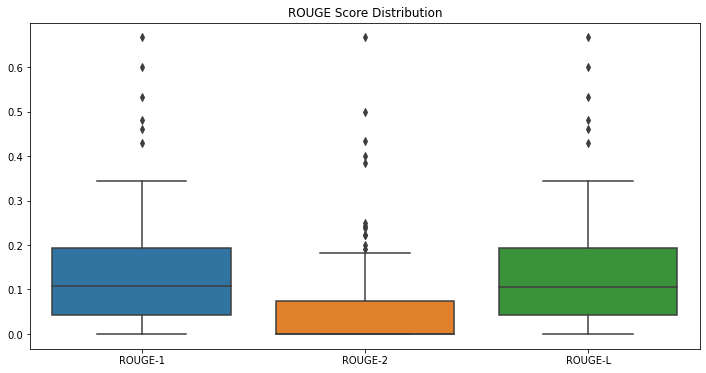

In [46]:
pred_texts = [result[0]["generated_text"] for result in pred_results]

compute_rouge(ref_labels, pred_texts )

# 2. SFT 모델

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import Adam
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments
from copy import deepcopy
import copy
import logging
import json
from dataclasses import dataclass

In [2]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [4]:
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

print(tokenizer)

GPT2TokenizerFast(name_or_path='skt/kogpt2-base-v2', vocab_size=51200, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=True)


In [5]:
from typing import Optional, Dict, Sequence

class SFT_dataset(Dataset):

    def __init__(self, data_path_1_SFT: str, tokenizer: transformers.PreTrainedTokenizer, verbose=False):
        super(SFT_dataset, self).__init__()
        logging.warning("Loading data...")

        pattern_instruction = 'prompt'  # instruction
        pattern_output = 'completion'  # response

        with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
            list_data_dict = json.load(json_file)

        PROMPT_DICT = {
            "prompt_input": (
                "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
            )
        }

        prompt_input = PROMPT_DICT["prompt_input"]

        sources = []
        for example in list_data_dict:
            tmp = prompt_input.format_map(example)
            sources.append(tmp)

        targets = []
        for example in list_data_dict:
            targets.append(f"{example[pattern_output]}{tokenizer.eos_token}")
        examples = [s + t for s, t in zip(sources, targets)]

        # sources_tokenized는 **입력 마스킹(masking)**에 쓰이고,
        # examples_tokenized는 전체 학습 텍스트 + 레이블용 토큰이다
        sources_tokenized = self._tokenize_fn(sources, tokenizer)  # source
        examples_tokenized = self._tokenize_fn(examples, tokenizer)  # source + target

        source_ids = sources_tokenized["input_ids"]
        input_ids = examples_tokenized["input_ids"]
        # loss 계산시 label을 정의하는 부분으로, input_ids를 그대로 copy하되
        # prompt 부분은 필요없으므로 lable에서 prompt 부분은 -100으로 masking한다. 
        labels = copy.deepcopy(input_ids)
        for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
            label[:source_len] = -100
       

        data_dict = dict(input_ids=input_ids, labels=labels, source_ids=source_ids)

        self.input_ids = data_dict["input_ids"]
        self.labels = data_dict["labels"]
        self.source_ids = data_dict["source_ids"]
        logging.warning("Loading data done!!: %d"%(len(self.labels)))


    def _tokenize_fn(self, strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer) -> Dict:
        tokenized_list = [
            tokenizer(
                text,
                return_tensors="pt",
                padding="longest",
                max_length=tokenizer.model_max_length,
                truncation=True,
            )
            for text in strings
        ]
        input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
        input_ids_lens = labels_lens = [
            tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list
        ]
        return dict(
            input_ids=input_ids,
            labels=labels,
            input_ids_lens=input_ids_lens,
            labels_lens=labels_lens,
        )


    def __len__(self):
        return len(self.input_ids)


    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i], source_ids=self.source_ids[i])

In [6]:
@dataclass
class DataCollatorForSupervisedDataset(object): 

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        # batch 내 label 시퀀스를 길이에 맞춰 패딩(padding)
        # padding_value= -100 : 짧은 시퀀스를 맞추기 위해 채울 값
        # PyTorch의 nn.CrossEntropyLoss()에서는 ignore_index=-100이 기본값
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value= -100)
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

In [7]:
data_save_path_SFT = './data/clean_kochatgpt_1_SFT.jsonl'

all_train_dataset = SFT_dataset(data_path_1_SFT=data_save_path_SFT, tokenizer=tokenizer)
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

print(type(all_train_dataset))
print(len(all_train_dataset))
print('input : %s'%all_train_dataset.input_ids[0])
print('output: %s'%all_train_dataset.labels[0])

<class '__main__.SFT_dataset'>
11992
input : tensor([  739,   378,   378,   378, 14659, 13394, 37091, 10651,   383, 25841,
         8006, 14914,   375,  7673, 20479,  8091, 22311,  9036, 30902,  8084,
          739, 10604,   375,   378,   378,   378, 41951,   454,  9549, 20549,
          383,  8142,  7192, 14914, 37767, 13753,  8263,  7166,   739,  8352,
         7659,  9639, 11481, 25585, 13600,  8022,  9378, 11532,  9887, 11218,
         9111, 16913,  7182, 36510, 10351, 10561,  9128, 20479,  8091,  9065,
         9446, 33869, 11481, 46311, 11481, 26367,  6958,  9030,  9882, 12317,
        25882,  9209,  8708,  7172,  7182, 36510, 10351,  9036, 12168, 10529,
        15989,  9719, 15434, 10552, 11188,  9355, 11481,  9036, 15805, 11300,
        11846,  9146, 16913,  7182, 36510,  9181,  7397, 15806, 13480, 11342,
        17596,  9161, 19996,  9025, 25006, 18595,  9966, 12592, 10751, 11814,
         8711,  9046, 12450,  9117,  7377,  7172,  7182, 36510,     1])
output: tensor([ -100,  -

In [8]:
from torch.utils.data import random_split

total_len = len(all_train_dataset)

# train 80%, val 10%, test 10%로 나누기
train_size = int(0.8 * total_len)
val_size = int(0.1 * total_len)
test_size = total_len - train_size - val_size  # 남는 거 처리

# 랜덤 시드 고정
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(all_train_dataset, [train_size, val_size, test_size], generator=generator)


print(f"Train: {len(train_dataset)}")
print(f"Validation: {len(val_dataset)}")
print(f"Test: {len(test_dataset)}")

Train: 9593
Validation: 1199
Test: 1200


In [15]:
output_dir = os.getenv('HOME')+'/aiffel/KoChatGPT/test'

training_args = TrainingArguments(
    output_dir,
    overwrite_output_dir=True,
    evaluation_strategy="epoch",        #evaluation하는 빈도
    logging_strategy="epoch",           # epoch마다 로그 기록
    learning_rate = 2e-5,               #learning_rate
    num_train_epochs=3,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    warmup_steps=5,
    prediction_loss_only=True,
    logging_dir="./sft_logs",
    fp16 = True
    )

trainer = Trainer(
    model=model,
    
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset, 
    tokenizer=tokenizer,
    compute_metrics=compute_metrics 
)

In [16]:
trainer.train()
model.save_pretrained('./modles/output_1_SFT')

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.541400,2.339253
2,1.890400,2.300440
3,1.468500,2.314573


In [27]:
trainer.evaluate(test_dataset)

{'eval_loss': 2.311244010925293,
 'eval_runtime': 22.5163,
 'eval_samples_per_second': 53.295,
 'eval_steps_per_second': 53.295,
 'epoch': 3.0}

Step: 9593, Epoch: 1.0, Loss: 2.5414
Step: 9593, Epoch: 1.0, Eval Loss: 2.3392531871795654
Step: 19186, Epoch: 2.0, Loss: 1.8904
Step: 19186, Epoch: 2.0, Eval Loss: 2.3004400730133057
Step: 28779, Epoch: 3.0, Loss: 1.4685
Step: 28779, Epoch: 3.0, Eval Loss: 2.314573287963867


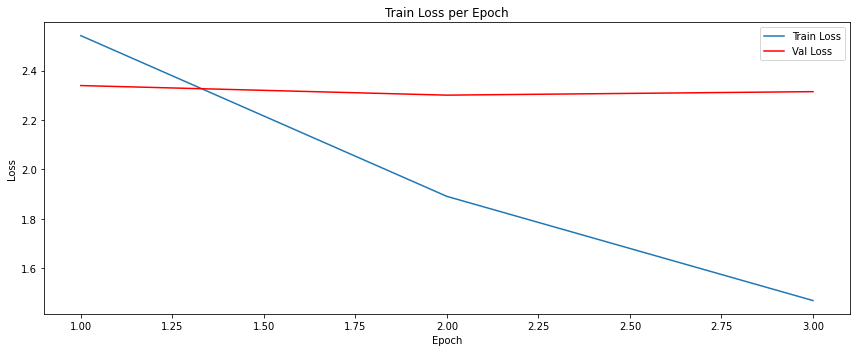

In [17]:
# 학습 후 로그 가져오기
sft_logs = trainer.state.log_history

display_train_graph(logs = sft_logs)

**Generate**

In [18]:
# 허깅페이스의 pipleline 클래스를 사용하여 generator 생성
generator = pipeline('text-generation', model='./modles/output_1_SFT', tokenizer=tokenizer)

generation_args = dict(   
    num_beams=4,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id=375, # \n   
    max_new_tokens=64,
    do_sample=True,
    top_k=50,
    early_stopping=True
)

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

test_count = 100 # 개수를 줄여보자

# inputs
inputs = []
for idx, data in enumerate(test_dataset) : 
    if idx >= test_count :
        break
    input_ids = data['source_ids']
    input_text = tokenizer.decode(input_ids , skip_special_tokens=True)
    
    inputs.append(input_text)
       
print(len(inputs))

# references 
ref_labels = []
for idx, data in enumerate(test_dataset) : 
    if idx >= test_count :
        break
    label_ids = data['labels']
    label_text = tokenizer.decode([token for token in  label_ids  if token != -100], skip_special_tokens=True)
    
    ref_labels.append(label_text)
    
print(len(ref_labels))


list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt' : tmp}) for tmp in inputs]

#list_result = generator(list_prompt, **generation_args)   

from tqdm import tqdm

pred_results = []
for input_text in tqdm(list_prompt, desc="Generating"):
    result = generator(input_text, **generation_args)
    pred_results.append(result)


100
100


Generating:   0%|          | 0/100 [00:00<?, ?it/s]/opt/conda/lib/python3.9/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
Generating: 100%|██████████| 100/100 [08:31<00:00,  5.11s/it]


In [19]:
print(type(pred_results))
pred_results[0]

<class 'list'>


[{'generated_text': '### Instruction(명령어):\n### Instruction(명령어):\n변명거리 생각해봐\n\n### Response(응답):\n\n### Response(응답):저는 인공지능 언어모델로써 변명을 할 수 없습니다. 하지만, 저는 항상 여러분의 질문에 답변해드릴 준비가 되어있습니다. 어떤 문제가 있으신가요? 제가 도와드릴 수 있는 것이 있다면 언제든지 말씀해주세요! 다시 한번'}]

In [20]:
cnt = 0
for prompt, ref, result in zip(list_prompt, ref_labels, pred_results):
    print()
    print("[Prompt]", prompt)
    print("[Ref   ]", ref)
    print("[Gen   ]", (result[0]['generated_text']))
    cnt +=1
    if cnt >= 3 :
        break


[Prompt] ### Instruction(명령어):
### Instruction(명령어):
변명거리 생각해봐

### Response(응답):

### Response(응답):
[Ref   ] 1. 시간이 부족해서 일이나 공부가 바쁘다는 것을 이유로 시간이 부족해서라는 변명을 할 수 있습니다. 2. 기분이 안 좋아서 정신적인 상태가 안 좋아서 일이나 공부에 집중을 못하겠다는 변명을 할 수 있습니다. 3. 장소를 잘못 선택했어서 공부나 작업을 할 때 조용한 장소나 적절한 공간을 선택하지 않아서 집중력이 떨어졌다는 변명을 할 수 있습니다. 4. 건강상의 이유로 건강문제로 인해 일이나 공부에 집중력이 떨어졌다는 변명을 할 수 있습니다. 5. 다른 이유로 인해 예상치 못한 일이나 사건으로 인해 일이나 공부에 집중력이 떨어졌다는 변명을 할 수 있습니다.
[Gen   ] ### Instruction(명령어):
### Instruction(명령어):
변명거리 생각해봐

### Response(응답):

### Response(응답):저는 인공지능 언어모델로써 변명을 할 수 없습니다. 하지만, 저는 항상 여러분의 질문에 답변해드릴 준비가 되어있습니다. 어떤 문제가 있으신가요? 제가 도와드릴 수 있는 것이 있다면 언제든지 말씀해주세요! 다시 한번

[Prompt] ### Instruction(명령어):
### Instruction(명령어):
방탄소년단은 한국 가수 최초로 몇 개의 앨범이 연속으로 빌보드 200차트에 올랐나?

### Response(응답):

### Response(응답):
[Ref   ] 방탄소년단은 5개의 앨범이 연속으로 빌보드 200차트에 올랐습니다. the most beautiful moment in life, part 2, the most beautiful moment in life young forever, wings, love yourself her, love yourself tear
[Gen   ] ### Instruction(명령어):
#

In [23]:
result = pred_results[0]
response_raw = result[0]["generated_text"]
response_clean = response_raw.split("### Response(응답):")[-1].strip()
print(response_clean)

저는 인공지능 언어모델로써 변명을 할 수 없습니다. 하지만, 저는 항상 여러분의 질문에 답변해드릴 준비가 되어있습니다. 어떤 문제가 있으신가요? 제가 도와드릴 수 있는 것이 있다면 언제든지 말씀해주세요! 다시 한번


In [26]:
print(ref_labels[0])

1. 시간이 부족해서 일이나 공부가 바쁘다는 것을 이유로 시간이 부족해서라는 변명을 할 수 있습니다. 2. 기분이 안 좋아서 정신적인 상태가 안 좋아서 일이나 공부에 집중을 못하겠다는 변명을 할 수 있습니다. 3. 장소를 잘못 선택했어서 공부나 작업을 할 때 조용한 장소나 적절한 공간을 선택하지 않아서 집중력이 떨어졌다는 변명을 할 수 있습니다. 4. 건강상의 이유로 건강문제로 인해 일이나 공부에 집중력이 떨어졌다는 변명을 할 수 있습니다. 5. 다른 이유로 인해 예상치 못한 일이나 사건으로 인해 일이나 공부에 집중력이 떨어졌다는 변명을 할 수 있습니다.


📊 평균 ROUGE 점수
ROUGE-1 F1: 0.1022
ROUGE-2 F1: 0.0282
ROUGE-L F1: 0.1011


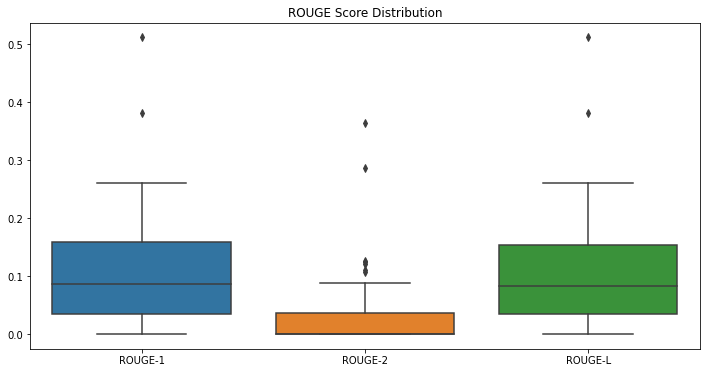

In [24]:

pred_texts = [
    r[0]["generated_text"].split("### Response(응답):")[-1].strip()
    for r in pred_results
    ]
    
compute_rouge(ref_labels, pred_texts )

# < 회고 >

### 테스트 목표 : 루브릭 1번
1. KoGTP와 SFP의 훈련 결과를 loss, perplexity를 비교
2. test set에 대한 generate의 결과를 Rogue로 비교
3. generate의 결과 중 몇개를 출력하여 정성적으로 비교

### 어려운점 및 시험 기록
1. CUDA OOM 문제로 
   - tokenizer의 max_length를 512 -> 384로 변경 
   - batch size 1로 변경
   - prediction_loss_only=True이면 loss 정보만 출력되어서 False로 했다가, 다시 True로 바꿔봄
       + perplexity는 출력되지 않음
2. generate 
   - generate는 test_dataset 1200개중 100개만 사용
3. 시간 문제로
   - KoGPT는 epoch 1만 돌렸는데, SFT 3 epoch(1시간40분 소요) 결과와 비교하였음
   <- 시간이 되면 KoGPT도 3 epoch 수행할 것!
   - trainer.evaluate는 하지 않음

### test summary 

✅ ROUGE 점수

| Metric  | KoGPT F1 Score | SFT F1 Score |
| ------- | -------- |-------- |
| ROUGE-1 | 0.1404   |  0.1022 |
| ROUGE-2 | 0.0647   |  0.0282|
| ROUGE-L | 0.1394   |  0.1011|

✅ Loss 비교 

| Epoch | KoGPT Training Loss | KoGPT Validation Loss | SFT Training Loss | SFT Validation Loss |
| ----- | ------------- | --------------- |------------- | --------------- |
| 1     | 2.556800      |2.297744         |  2.5414      | 2.3393          |
| 2     |               |                 |1.8904        | 2.3004          |
| 3     |               |                 |1.4685        | 2.3146          |

✅ 생성문장 비교 
- prompt : 변명거리를 생각해 봐
- KoGPT : 제가 ai 챗봇이기 때문에, 어떤 문제가 있는지 자세히 설명해주시면 답변을 드릴 수 있을 것 같습니다.
- SFT : 저는 인공지능 언어모델로써 변명을 할 수 없습니다. 하지만, 저는 항상 여러분의 질문에 답변해드릴 준비가 되어있습니다. 어떤 문제가 있으신가요? 제가 도와드릴 수 있는 것이 있다면 언제든지 말씀해주세요! 다시 한번

- prompt : boney m. 의 잠보 하쿠나 마타타를 부를 사람은?
- KoGPT : 저는 ai 어시스턴트이기 때문에, 이 질문에 대한 답변을 제공할 수 없습니다.
- SFT : 저는 ai 어시스턴트이기 때문에, boney market 이 누구인지 알 수 없습니다. 추가적인 정보를 제공해주시면 더 정확한 답변을 드릴 수 있을 것입니다., token 125 다시 한번 강조해 주시면 감사하겠습니다

✅ 종합 평가
1. Rouge 점수는 낮지만, SFT가 더 자연스러운 문장을 구사한다.
2. training loss는 둘다 비슷하다. training loss는 줄어들지만, validation loss는 줄어들지 않는다. 